In [1]:
import numpy as np
import lal
from scipy.interpolate import interp1d
from gwpy.timeseries import TimeSeries
import qnm
from pylab import *

import arviz as az
import pandas as pd
import seaborn as sns
import bilby

import ringdown

sns.set_context('notebook')
sns.set_palette('colorblind')

In [2]:
mag_from_nr=np.array([  0.13657646 +0.95055905j,   3.14657959 -2.71266413j,
       -10.84170677 +3.607406j  ,  22.67958241 -8.01885436j,
       -30.44795174+19.91714543j,  22.09429848-26.19835642j,
        -7.43071591+15.89029183j,   1.0005728  -3.63046079j])

In [7]:
def planck_window(t, tMin=0., tMax=1., tol=.005, rolloff=False):
    """
A smooth function f mapping [tMin, tMax] to [0, 1], with
f(tMin)=0, f(tMax)=1, all derivatives -> 0 as t->0 or t->tMax.
f(t) = 1/(1 + exp(z)) where z = 1/t - 1/(1-t) for the case
tMin=0, tMax=1.
tol controls the minimum deviation of t from 0 or tMax, with
a tol of .005 giving abs(z) < ~200, where exp(z) is 1.e86 or 1.e-86

If rolloff, instead has f(0)=1, f(tMax)=0.
    """
    if rolloff:
        return helper.planck_window(-t, tMin=-tMax, tMax=-tMin, tol=tol)

    if tMax==1. and tMin==0.:
        # If t <= .005, z >= 200. - 1./199. and exp(z) > 1.e86 ~ infinity
        # Similar for t > .995 but exp(z) < 1.e-86 ~ 0
        safe = (t>tol)*(t<(1.-tol))
        safeT = safe*t + (1. - safe)*.5 # use t = 0.5 temporarily for unsafe values
        safeZ = 1./safeT - 1./(1. - safeT)
        return safe*1./(1. + np.exp(safeZ)) + (t >= (1.-tol))

    return planck_window((t-tMin)/(tMax-tMin))

In [8]:
def load_data(iota,beta,t_unit):
    h2m2=np.loadtxt('Y_l2_m-2.dat')
    h22=np.loadtxt('Y_l2_m2.dat')
    time=h22[:,0]-3692.7480095302817

    h2=(h22[:,1]+1j*h22[:,2])*lal.SpinWeightedSphericalHarmonic(iota,beta,-2,2,2)\
    +(h2m2[:,1]+1j*h2m2[:,2])*lal.SpinWeightedSphericalHarmonic(iota,beta,-2,2,-2)
#     h2=(h22[:,1]+1j*h22[:,2])
    ts=np.arange(time[0]+50,time[-1],0.1)
    dtcut=ts[1]-ts[0]
    h2int=interp1d(time,h2)(ts)
    partition=2
    padlen=2**(3+int(np.ceil(np.log2(len(h2int)))))-len(h2int)
    ini_filter=planck_window(ts, tMin=ts[0], tMax=ts[0]+400)
    h2pad=np.pad(h2int*ini_filter,(padlen//partition,padlen-(padlen//partition)),'constant', constant_values=(0, 0))
    end1=ts[-1]+(padlen-(padlen//partition))*dtcut
    end2=ts[0]-(padlen//partition)*dtcut

    tpad=np.pad(ts,(padlen//partition,padlen-(padlen//partition)),'linear_ramp', end_values=(end2, end1))
#     tpad-=tpad[0]
    return tpad*t_unit,(h2pad)

In [9]:
def fac(ffreq,l,m,n,chi=0.692085186818):
    ome=qnm.modes_cache(s=-2,l=l,m=m,n=n)(a=chi)[0]
#     return -1j*(ffreq-ome)
    return (ffreq-ome)/(ffreq-np.conj(ome))*(ffreq+np.conj(ome))/(ffreq+ome)

In [10]:
def decayplot(t,l,m,n):
    ome=qnm.modes_cache(s=-2,l=l,m=m,n=n)(a=0.692085186818)[0]/(Mf*t_unit)
    return [t[t>-0.01],np.exp(-1j*ome*t)[t>-0.01]]

In [11]:
def NR_injection_into_Bilby(time,tpad,h2pad,M_tot,solar_to_distance,dis, **waveform_kwargs):
    hplus_interp_func = interp1d(tpad, np.real(h2pad), bounds_error=False, fill_value=0)
    hcross_interp_func = interp1d(tpad, -np.imag(h2pad), bounds_error=False, fill_value=0)
    hplus = hplus_interp_func(time)/dis#*M_tot*solar_to_distance
    hcross = hcross_interp_func(time)/dis#*M_tot*solar_to_distance
    return {'plus': hplus, 'cross': hcross}

In [12]:
Mf=0.952032939704
chi=0.692085186818
M_est_total=65/Mf

In [508]:
def inject_gau(distance,M_tot):

    solar_to_distance=2950./2
    solar_to_time=2950./2/299792458
    t_unit=M_tot*solar_to_time
    Mpc=30860000000000004*1000104.4887813144596
    dis=distance
    

    duration = 4
    sampling_frequency = 2048.*4

    
    iota=np.pi/3
    beta=np.pi/3*0

    tpad,h2pad=load_data(iota,beta,t_unit)
    
    tfinal=np.arange(-duration/2,duration/2,1./sampling_frequency)
    h_int=NR_injection_into_Bilby(tfinal,tpad,h2pad,M_tot,solar_to_distance,dis)
    
    rng = np.random.default_rng(12345)
    signal=h_int['plus']+ rng.normal(0, 1, len(tfinal))

    
    fpsi422=np.fft.rfft(h_int['plus'],norm='ortho')
    ffreq=np.fft.rfftfreq(len(signal),d=(tfinal[1]-tfinal[0])/(Mf*t_unit))*2*np.pi
    return tfinal,signal,ffreq,fpsi422,t_unit

In [633]:
tfinal,signal,ffreq,fpsi422,t_unit=inject_gau(distance=0.004,M_tot=M_est_total)
cond_data=np.fft.irfft(fpsi422,norm='ortho',n=len(signal))

In [634]:
h_raw_strain =ringdown.Data(signal, index=tfinal)
signal_filter=ringdown.Data(cond_data, index=tfinal)

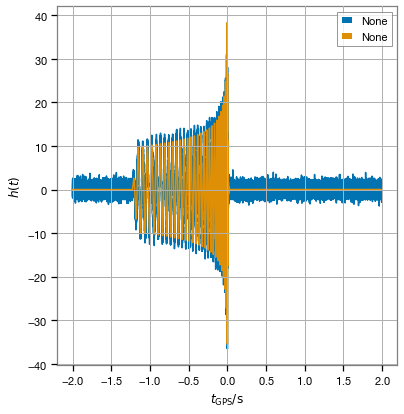

In [635]:
h_raw_strain.plot(label=h_raw_strain.ifo)
signal_filter.plot()
xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$');
ylabel(r'$h(t)$');
legend(loc='best');

In [664]:
def set_data(M_est,chi_est):
    srate = 2048
    acf = ringdown.AutoCovariance(zeros_like(h_raw_strain), delta_t=h_raw_strain.delta_t)
    acf.iloc[0] = 1
    fit1 = ringdown.Fit(model='mchi_aligned', modes=[(1, -2, 2, 2, 1)])
    fit1.add_data(h_raw_strain, acf=acf)
    
    t_unit=M_est_total*Mf*2950./2/299792458
    t0=0*t_unit
#     T = (100)*t_unit-t0
    T = 0.08
    fit1.set_target(t0, duration=T)
    fit1.condition_data(ds=int(round(h_raw_strain.fsamp/srate)), flow=20,preserve_acfs=True)
    
    fit1.filter_data(chi_est,M_est,2,2,0)
    fit1.filter_data(chi_est,M_est,2,2,1)
    fit1.filter_data(chi_est,M_est,2,2,2)
    fit1.filter_data(chi_est,M_est,2,2,3)
    wd1 = fit1.analysis_data
    return fit1,wd1

In [665]:
def compute_likelihood(fit1,wd1):
    Ls=fit1.obtain_L()
    strains=np.array([s.values for s in wd1.values()])
    times=np.array([array(d.time) for d in wd1.values()])
    likelihood=0
    for i in range(len(strains)):
        norm=np.sqrt(np.sum(abs(np.dot(np.linalg.inv(Ls[i]),Ls[i])-np.identity(len(Ls[i])))**2))
        if abs(norm)>1e-8:
            raise ValueError("inverse of L is not correct")
        whitened=np.dot(np.linalg.inv(Ls[i]),strains[i])
        likelihood-=0.5*np.dot(whitened,whitened)
    return likelihood

In [666]:
def total(M_est,chi_est):
    fit1,wd1=set_data(M_est,chi_est)
    likelihood=compute_likelihood(fit1,wd1)
    return likelihood

In [667]:
chispace=np.arange(0.1,0.95,0.03)
massspace=np.arange(34,100,2)

In [668]:
finalfinal=[]
for j in chispace:
    final=[]
    for i in massspace:
        final.append(total(i,j))
    finalfinal.append(final)
finalfinal=np.array(finalfinal)

In [669]:
X, Y = np.meshgrid(massspace,chispace)

Text(0.5, 1.0, '$\\mathcal{F}_{220}+\\mathcal{F}_{221}$')

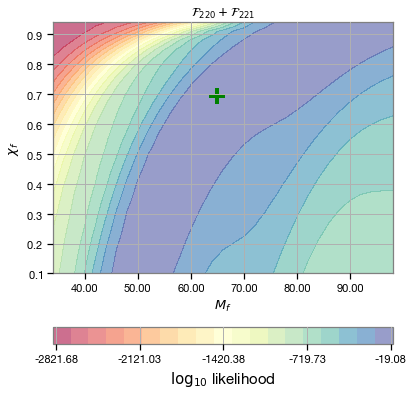

In [670]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours=ax.contourf(X, Y, finalfinal,20, cmap='Spectral', origin='lower',alpha=0.6,linestyles='--')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.scatter(x=M_est_total*Mf,y=chi,s=255,marker='+',c='g',linewidths=4,label='IMR')
cbar=fig.colorbar(contours,orientation="horizontal", pad=0.15,format='%3.2f')

cbar.set_label(r'$\log_{10}$ likelihood',fontsize=15)
cbar.set_ticks(np.linspace(np.min(finalfinal),np.max(finalfinal),5))
pl.xlabel(r'$M_f$',fontsize=13)
pl.ylabel(r'$\chi_f$',fontsize=13)

# contoursnew=ax.contour(contours,levels=[-158,-152],linewidths=2,linestyles='--',colors='k')

# counterlabel=ax.clabel(contoursnew,contoursnew.levels
#                        , inline=True, fontsize=12,fmt='%2.1f'
#                        ,rightside_up=False,use_clabeltext=True,colors='k')


# for l in counterlabel:
#     l.set_rotation(0)

# ax.set_title(r'$\mathcal{F}_{220}$')
ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')
# pl.savefig('vary_filter/injection_t14.pdf')

In [671]:
import os
os.system('say "hi"')

0